In [ ]:
import csv
import json
import math
import requests
from datetime import datetime, timedelta, date
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from scipy.stats import mannwhitneyu, spearmanr

import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
DATA_DIR = Path('/content')
SALES_CSV   = DATA_DIR/'daily_sales_by_category_2021_2022.csv'
TRENDS_CSV  = DATA_DIR/'gogletrendsDATA.csv'

In [ ]:
sales = []
with open(SALES_CSV, encoding='utf-8') as f:
    for row in csv.DictReader(f):
        sales.append({
            'date'  : datetime.strptime(row['date'], '%Y-%m-%d'),
            'Sweet' : float(row['Sweet']),
            'Savory': float(row['Savory']),
            'Other' : float(row['Other'])
        })

In [ ]:
trends = []
with open(TRENDS_CSV, encoding='utf-8') as f:
    for row in csv.DictReader(f):
        trends.append({
            'date'           : datetime.strptime(row['date'], '%Y-%m-%d'),
            'comment_maigrir': float(row['comment perdre du poids: (France)']),
            'regime'         : float(row['régime: (France)'])
        })

In [ ]:
start, end = min(r['date'] for r in sales), max(r['date'] for r in sales)
all_dates  = [start + timedelta(days=i) for i in range((end-start).days + 1)]

tr_map = {r['date']: r for r in trends}
filled_tr = {}
last = tr_map.get(all_dates[0])

for d in all_dates:
    if d in tr_map:
        last = tr_map[d]
    filled_tr[d] = last

In [ ]:
data = []
for rec in sales:
    t = filled_tr[rec['date']]
    data.append({**rec, **{
        'regime'         : t['regime'],
        'comment_maigrir': t['comment_maigrir']
    }})
print("Sample:", data[:2])

Sample: [{'date': datetime.datetime(2021, 1, 2, 0, 0), 'Sweet': 170.0, 'Savory': 308.0, 'Other': 103.0, 'regime': 67.0, 'comment_maigrir': 5.0}, {'date': datetime.datetime(2021, 1, 3, 0, 0), 'Sweet': 158.0, 'Savory': 323.0, 'Other': 83.0, 'regime': 81.0, 'comment_maigrir': 8.0}]


In [ ]:
numeric_cols = ['Sweet','Savory','Other','regime','comment_maigrir']

# Outlier flags (IQR)
for col in numeric_cols:
    vals = np.array([r[col] for r in data])
    Q1, Q3 = np.percentile(vals, [25, 75])
    iqr_lo, iqr_hi = Q1 - 1.5*(Q3-Q1), Q3 + 1.5*(Q3-Q1)
    for r in data:
        r[f'{col}_outlier'] = (r[col] < iqr_lo) or (r[col] > iqr_hi)

# Date-based extras
for r in data:
    r['weekday']    = r['date'].strftime('%A')
    r['is_weekend'] = r['date'].weekday() >= 5
    r['month']      = r['date'].month

In [ ]:
holiday_raw = [
    "2021-01-01","2021-04-05","2021-05-01","2021-05-08","2021-05-13","2021-05-24",
    "2021-07-14","2021-08-15","2021-11-01","2021-11-11","2021-12-25",
    "2022-01-01","2022-04-18","2022-05-01","2022-05-08","2022-05-26","2022-06-06",
    "2022-07-14","2022-08-15","2022-11-01","2022-11-11","2022-12-25"
]
holidays = {datetime.strptime(d, '%Y-%m-%d') for d in holiday_raw}
for r in data:
    r['is_holiday'] = r['date'] in holidays

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform([[r[c] for c in numeric_cols] for r in data])
for i, r in enumerate(data):
    for j, col in enumerate(numeric_cols):
        r[f'{col}_scaled'] = X_scaled[i, j]

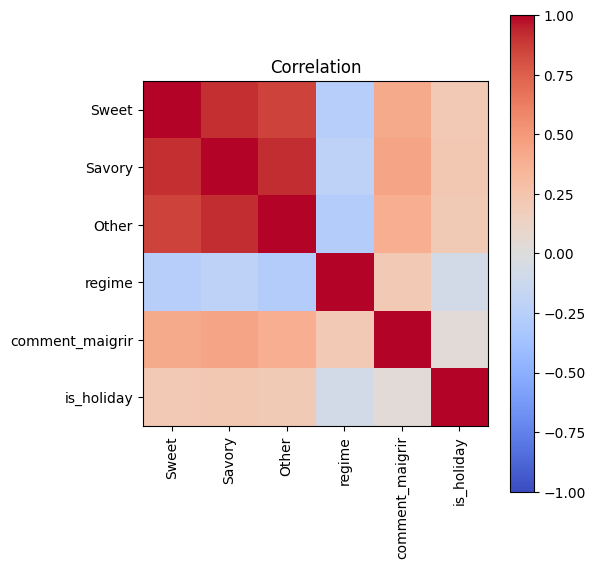

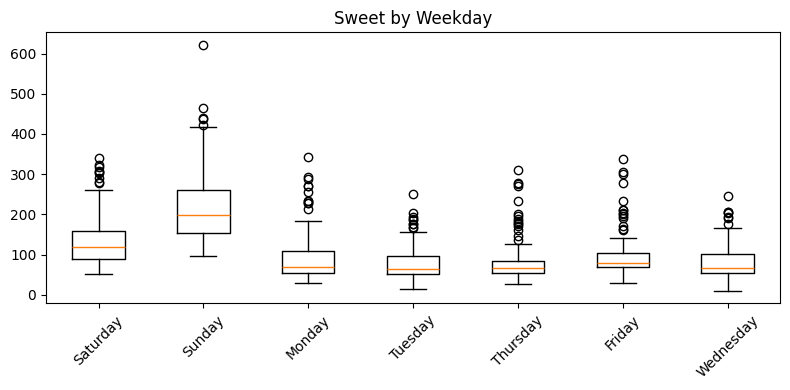

In [ ]:
# correlation heat-map
keys = numeric_cols + ['is_holiday']
corr = np.corrcoef(np.array([[r[k] for k in keys] for r in data]).T)

plt.figure(figsize=(6,6))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.xticks(range(len(keys)), keys, rotation=90)
plt.yticks(range(len(keys)), keys)
plt.colorbar()
plt.title("Correlation")
plt.tight_layout()
plt.show()

# weekday boxplot
groups={}
for r in data:
    groups.setdefault(r['weekday'], []).append(r['Sweet'])
plt.figure(figsize=(8,4))
plt.boxplot([groups[k] for k in groups], labels=list(groups))
plt.xticks(rotation=45)
plt.title("Sweet by Weekday")
plt.tight_layout()
plt.show()

In [ ]:
weekly = {}
for r in data:
    key = r['date'].isocalendar()[:2] # year and week
    w   = weekly.setdefault(key, {'count':0, **{m:0 for m in numeric_cols}})
    for m in numeric_cols:
        w[m] += r[m]
    w['count'] += 1

weekly_avg = {k: {m: v[m]/v['count'] for m in numeric_cols} for k,v in weekly.items()}
print("First 3 weekly means:", list(weekly_avg.items())[:3])

First 3 weekly means: [((2020, 53), {'Sweet': 164.0, 'Savory': 315.5, 'Other': 93.0, 'regime': 74.0, 'comment_maigrir': 6.5}), ((2021, 1), {'Sweet': 77.33333333333333, 'Savory': 216.5, 'Other': 59.0, 'regime': 78.66666666666667, 'comment_maigrir': 4.5}), ((2021, 2), {'Sweet': 77.83333333333333, 'Savory': 199.5, 'Other': 63.333333333333336, 'regime': 72.16666666666667, 'comment_maigrir': 4.666666666666667})]


In [ ]:
# choose 75th percentile of regime as cutoff
reg_vals = sorted(r['regime'] for r in data)
cutoff   = reg_vals[int(len(reg_vals)*0.75)]

def mw_u(metric):
    high = [r[metric] for r in data if r['regime'] > cutoff]
    low  = [r[metric] for r in data if r['regime'] <= cutoff]
    return mannwhitneyu(high, low).pvalue

print("Mann-Whitney p(Sweet) :", mw_u('Sweet'))
print("Mann-Whitney p(Savory):", mw_u('Savory'))

rho, p = spearmanr([r['regime'] for r in data],
                   [r['Sweet']  for r in data])
print(f"Spearman rho={rho:.3f}  p={p:.3f}")

Mann-Whitney p(Sweet) : 1.7018772814846978e-18
Mann-Whitney p(Savory): 3.2104795546201104e-11
Spearman rho=-0.272  p=0.000


In [ ]:
# getting weather data
def fetch_open_meteo_archive(lat=48.8566, lon=2.3522,
                             start='2021-01-01', end='2022-12-31'):
    """Return {date → {'t_max', 't_min', 'rain'}} using the archive API."""
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={start}&end_date={end}"
        "&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
        "&timezone=Europe%2FParis"
    )
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    js = r.json()
    if 'daily' not in js or not js['daily']['time']:
        raise RuntimeError("Open-Meteo archive returned no daily data")

    out = {}
    for i, d in enumerate(js['daily']['time']):
        out[datetime.strptime(d, '%Y-%m-%d')] = {
            't_max': js['daily']['temperature_2m_max'][i],
            't_min': js['daily']['temperature_2m_min'][i],
            'rain' : js['daily']['precipitation_sum'][i]
        }
    return out

weather = fetch_open_meteo_archive()
print("Fetched", len(weather), "weather rows.")

Fetched 730 weather rows.


In [ ]:
for r in data:
    w = weather.get(r['date'])
    if w:
        r.update(w)
    else:
        r.update({'t_max': math.nan, 't_min': math.nan, 'rain': math.nan})

numeric_cols += ['t_max','t_min','rain']
print("Weather merged. Sample:", data[0])

for r in data:
    for k in ('t_max', 't_min', 'rain'):
        if r.get(k) is None:
            r[k] = np.nan

Weather merged. Sample: {'date': datetime.datetime(2021, 1, 2, 0, 0), 'Sweet': 170.0, 'Savory': 308.0, 'Other': 103.0, 'regime': 67.0, 'comment_maigrir': 5.0, 'Sweet_outlier': np.False_, 'Savory_outlier': np.False_, 'Other_outlier': np.False_, 'regime_outlier': np.False_, 'comment_maigrir_outlier': np.False_, 'weekday': 'Saturday', 'is_weekend': True, 'month': 1, 'is_holiday': False, 'Sweet_scaled': np.float64(0.26264274061990217), 'Savory_scaled': np.float64(0.26807228915662645), 'Other_scaled': np.float64(0.24932249322493227), 'regime_scaled': np.float64(0.5074626865671642), 'comment_maigrir_scaled': np.float64(0.5), 't_max': 3.5, 't_min': -2.0, 'rain': 0.0}


In [ ]:
pairs = [(r['t_max'], r['Sweet'])
         for r in data
         if isinstance(r['t_max'], (int, float)) and not math.isnan(r['t_max'])]

if len(pairs) < 2:
    print("No valid weather rows – check the API call above.")
else:
    temps, sweets = zip(*pairs)
    rho, p = spearmanr(temps, sweets)
    print(f"Sweet vs t_max   Spearman rho={rho:.3f}   p={p:.4f}")

Sweet vs t_max   Spearman rho=0.379   p=0.0000


In [ ]:
df = pd.DataFrame(data).sort_values('date').reset_index(drop=True)

df['Sweet_lag1'] = df['Sweet'].shift(1)

df = df.dropna(subset=['Sweet_lag1']).reset_index(drop=True)

print("Feature table shape:", df.shape)
df.head()

Feature table shape: (599, 24)


,date,Sweet,Savory,Other,regime,comment_maigrir,Sweet_outlier,Savory_outlier,Other_outlier,regime_outlier,...,is_holiday,Sweet_scaled,Savory_scaled,Other_scaled,regime_scaled,comment_maigrir_scaled,t_max,t_min,rain,Sweet_lag1
0,2021-01-03,158.0,323.0,83.0,81.0,8.0,False,False,False,False,...,False,0.243067,0.283133,0.195122,0.716418,0.8,3.7,1.2,0.2,170.0
1,2021-01-04,48.0,219.0,48.0,85.0,5.0,False,False,False,False,...,False,0.063622,0.178715,0.100271,0.776119,0.5,2.9,1.5,0.3,158.0
2,2021-01-05,45.0,207.0,57.0,100.0,5.0,False,False,False,False,...,False,0.058728,0.166667,0.124661,1.000000,0.5,3.3,1.4,0.5,48.0
3,2021-01-07,54.0,202.0,54.0,83.0,6.0,False,False,False,False,...,False,0.073409,0.161647,0.116531,0.746269,0.6,3.9,-0.5,0.5,45.0
4,2021-01-08,81.0,169.0,66.0,73.0,3.0,False,False,False,False,...,False,0.117455,0.128514,0.149051,0.597015,0.3,3.5,-1.1,0.0,54.0


In [ ]:
target      = 'Sweet'
cat_cols    = ['weekday', 'is_weekend', 'month', 'is_holiday']
num_cols    = ['Sweet_lag1','Savory','Other',
               'regime','comment_maigrir','t_max','t_min','rain']

X = df[cat_cols + num_cols]
y = df[target]

split_date = pd.Timestamp('2022-04-01')
train_idx  = df['date'] < split_date
X_train, X_test = X[train_idx], X[~train_idx]
y_train, y_test = y[train_idx], y[~train_idx]

print(f"Train rows: {len(X_train)},  Test rows: {len(X_test)}")

Train rows: 419,  Test rows: 180


In [ ]:
# preprocessing
pre = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', StandardScaler(), num_cols)
        ])

# model and training
model = RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=42,
            n_jobs=-1)

pipe = Pipeline([('prep', pre),
                 ('rf',   model)])

pipe.fit(X_train, y_train)
print("Model fitted.")

Model fitted.


MAE  : 24.1
RMSE : 38.9
R²   : 0.849


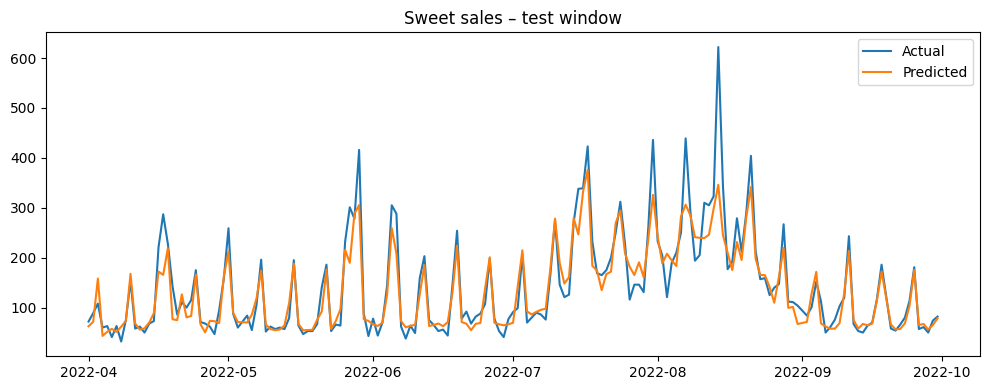

In [ ]:
# testing
pred = pipe.predict(X_test)

def rmse(a,b): return math.sqrt(mean_squared_error(a,b))

print(f"MAE  : {mean_absolute_error(y_test, pred):.1f}")
print(f"RMSE : {rmse(y_test, pred):.1f}")
print(f"R²   : {r2_score(y_test, pred):.3f}")

plt.figure(figsize=(10,4))
plt.plot(df.loc[~train_idx, 'date'], y_test,  label='Actual')
plt.plot(df.loc[~train_idx, 'date'], pred,   label='Predicted')
plt.title('Sweet sales – test window')
plt.legend()
plt.tight_layout()
plt.show()

             feature  importance
24            Savory    0.684353
25             Other    0.146238
3     weekday_Sunday    0.042135
7   is_weekend_False    0.021204
8    is_weekend_True    0.020416
23        Sweet_lag1    0.017722
26            regime    0.012582
29             t_min    0.011526
28             t_max    0.009619
27   comment_maigrir    0.007628


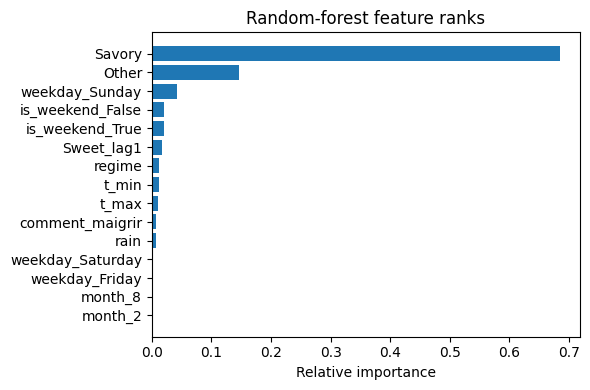

In [ ]:
# feature importance
cat_encoder = pipe.named_steps['prep'].named_transformers_['cat']
cat_names   = cat_encoder.get_feature_names_out(cat_cols)
num_names   = num_cols
feature_names = np.concatenate([cat_names, num_names])

importances = pipe.named_steps['rf'].feature_importances_

fi = (pd.DataFrame({'feature': feature_names,
                    'importance': importances})
      .sort_values('importance', ascending=False))

print(fi.head(10))

top_k = 15
plt.figure(figsize=(6,4))
plt.barh(fi['feature'].head(top_k)[::-1], fi['importance'].head(top_k)[::-1])
plt.xlabel('Relative importance')
plt.title('Random-forest feature ranks')
plt.tight_layout()
plt.show()